Цель тестирования - понять, оказывает ли какое-то влияние новая версия сайта на поведение пользователей.  
Соответственно, нулевая гипотеза - новая версия сайта не оказывает никакого влияния, альтернативная - новая версия изменила поведение пользователей.  
В качестве метрики будем использовать конверсию посещения сайта в покупку, то есть долю тех, кто купил, от тех, кто зашёл на сайт.  
Старую версию сайта без фотографий будем показывать пользователям контрольной группы, новую версию - пользователям тестовой группы.

Импортируем нужные библиотеки и загрузим датасет

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
df = pd.read_csv("datasets/bakery.csv")

In [20]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


### Предобработка данных

In [21]:
df.shape[0]

294478

В таблице содержатся данные о 294478 пользователях

In [22]:
df.user_id.nunique()

290584

Из них уникальных пользователей - 290584. Значит, есть пользователи, которые посетили страницу больше одного раза и, возможно, видели оба варианта страницы. Это может привести к некорректному результату. Оставим записи только о тех пользователях, которые находятся в контрольной группе и видели старую версию, и о пользователях, которые находятся в тестовой группе и видели новую версию

In [23]:
df = df.loc[((df.group == 'control') & (df.landing_page == 'old_page')) \
       | ((df.group == 'treatment') & (df.landing_page == 'new_page'))]

In [24]:
df.shape[0]

290585

Теперь число пользователей - 290585, что на один больше, чем количество уникальных пользователей. Скорее всего, какой-то пользователь был помещён и в контрольную, и в тестовую группу. Оставим только одну запись

In [25]:
df = df.drop_duplicates(subset=['user_id'], keep='first')

In [26]:
df.shape[0] == df.user_id.nunique() 

True

Данные очищены и готовы к анализу

### Анализ данных

Проверим, что количество пользователей в контрольной и тестовой группе примерно одинаково

In [27]:
df.groupby('group').count()

,user_id,timestamp,landing_page,converted
group,,,,
control,145274,145274,145274,145274
treatment,145310,145310,145310,145310


<AxesSubplot:>

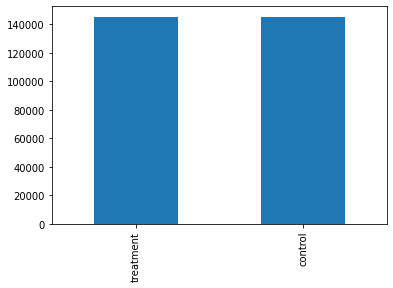

In [28]:
df.group.value_counts().plot(kind='bar')

Таким образом, различия в размерах групп вряд ли повлияют на результаты статистического анализа

Считаем конверсию

In [29]:
metrics = df.groupby('group', as_index=False).agg({'user_id': 'count', 'converted': 'sum'})
metrics['conversion'] = (metrics.converted / metrics.user_id * 100).round(2)
metrics

,group,user_id,converted,conversion
0,control,145274,17489,12.04
1,treatment,145310,17264,11.88


Конверсия тестовой группы ухудшилась

Есть ли неслучайная разница между группами? Действительно ли метрика ухудшилась или это погрешность?
Проверим.  
Воспользуемся критерием хи-квадрат для анализа конверсии

In [30]:
import statsmodels.stats.proportion as proportion

In [31]:
chi2stat, pval, table = proportion.proportions_chisquare(metrics['converted'], metrics['user_id'])

In [32]:
alpha = 0.05  # уровень статистической значимости

In [33]:
print(pval < alpha)

False


p-value меньше уровня статистической значимости, следовательно, статистически значимой разницы в конверсии между двумя группами не обнаружено

А были ли у нас шансы увидеть какую-то разницу между группами? Вычислим мощность нашего теста при использовании критерия хи-квадрат

In [34]:
import statsmodels.stats.power as smp

In [35]:
chipower = smp.GofChisquarePower()

In [36]:
conversion_control = metrics.conversion.values[0] / 100
conversion_treatment = metrics.conversion.values[1] / 100
nobs = min(metrics['user_id'])

In [37]:
def chi2_effect_size(p0, p1):
    return np.sqrt(((p0 - p1)**2 / p0))

In [38]:
chipower.solve_power(effect_size = chi2_effect_size(conversion_control, conversion_treatment), nobs=nobs, alpha=pval, power=None)

0.6734930128809633

Получаем достаточно низкое значение - 67%. Стандартным значением мощности является 80% и выше.  
Значит, с вероятностью более чем 32% мы бы не увидели статистически значимых отличий там, где они существуют.

Вычислим количество наблюдений, необходимых для получения желаемого уровня мощности

In [39]:
power = 0.8

In [40]:
size_of_each_test_group = chipower.solve_power(effect_size = chi2_effect_size(conversion_control, conversion_treatment), 
            nobs=None, alpha=alpha, power=power)
size_of_each_test_group

369141.72082925116

Умножим на 2, так как групп 2

In [41]:
2*size_of_each_test_group

738283.4416585023

### Вывод
Необходимо продолжить набор данных и только потом подводить итоги эксперимента